In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import tensorflow as tf

from kgl_wheat.utils import postprocess_bboxes, read_train_csv, get_train_val_split
from kgl_wheat import config
from kgl_wheat.dataset import get_dataset
from kgl_wheat.efficientdet.layers import(
    FixedDropout,
    BatchNormalization,
    wBiFPNAdd,
    ClipBoxes,
    RegressBoxes,
    FilterDetections
)
from kgl_wheat.efficientdet.model import efficientdet

In [2]:
tf.random.set_seed(22)
np.random.seed(22)

image_paths, bboxes, image_sources = read_train_csv(
    train_csv_path=config.TRAIN_LABELS_FILE,
    train_images_dir=config.TRAIN_IMAGES_DIR
)

train_image_paths, train_bboxes, val_image_paths, val_bboxes = \
    get_train_val_split(
        image_paths=image_paths,
        image_bboxes=bboxes,
        image_sources=image_sources,
        seed=config.SEED,
        train_size=config.TRAIN_SIZE
    )

val_dataset = get_dataset(
    image_paths=val_image_paths,
    bboxes=None
)

model, prediction_model = efficientdet(
        num_classes=1,
        weighted_bifpn=True,
        freeze_bn=True,
        score_threshold=config.SCORE_THRESHOLD
    )

prediction_model.load_weights(config.MODEL_WEIGHTS_PATH, by_name=True)

# prediction_model = tf.keras.models.load_model(
#     filepath=config.MODEL_WEIGHTS_PRED_PATH,
#     custom_objects={
#         'FixedDropout': FixedDropout,
#         'BatchNormalization': BatchNormalization,
#         'wBiFPNAdd': wBiFPNAdd,
#         'ClipBoxes': ClipBoxes,
#         'RegressBoxes': RegressBoxes,
#         'FilterDetections': FilterDetections
#     }
# )

In [3]:
pred_bboxes, pred_scores, pred_labels = prediction_model.predict(val_dataset, verbose=1)

pred_bboxes, pred_scores, pred_labels = np.squeeze(pred_bboxes), np.squeeze(pred_scores), np.squeeze(pred_labels)

pred_bboxes = postprocess_bboxes(bboxes=pred_bboxes, height=config.IMAGE_SIZE, width=config.IMAGE_SIZE)

264/264 [==============================] - 104s 392ms/step


In [4]:
pred_bboxes_filtered = []
pred_scores_filtered = []
for image_pred_bboxes, image_pred_scores in zip(pred_bboxes, pred_scores):
    indices = image_pred_scores > config.SCORE_THRESHOLD
    pred_bboxes_filtered.append(image_pred_bboxes[indices])
    pred_scores_filtered.append(image_pred_scores[indices])

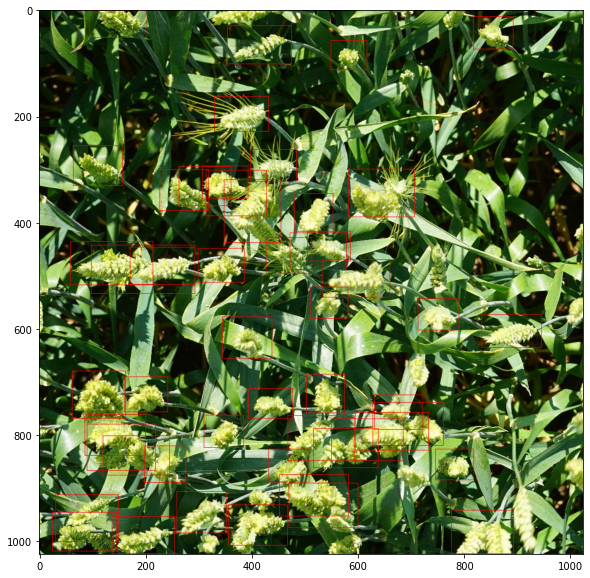

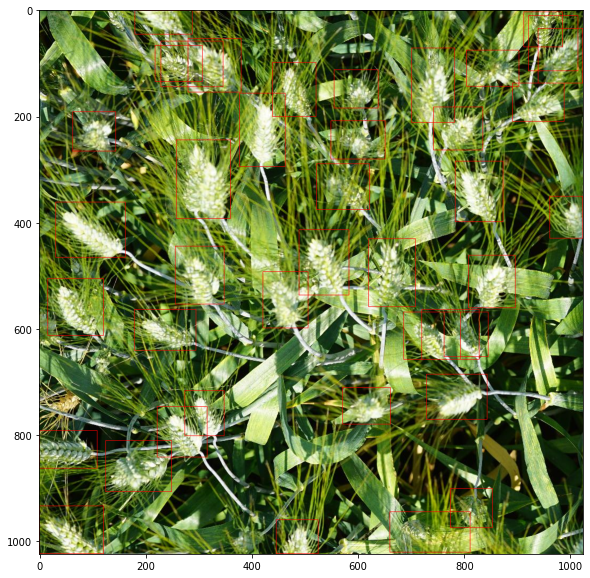

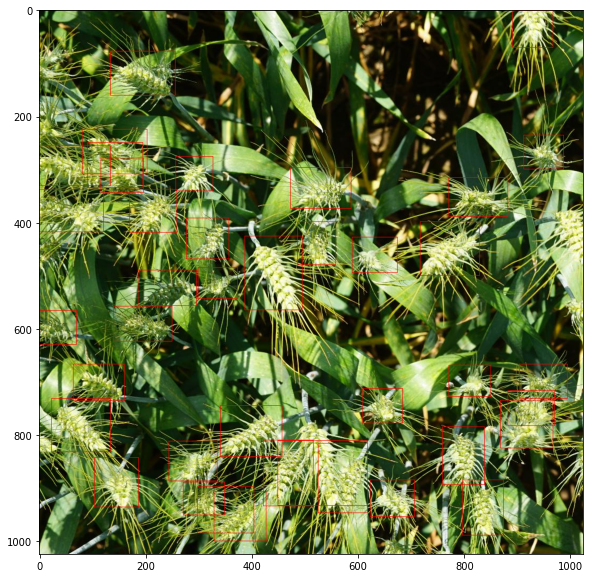

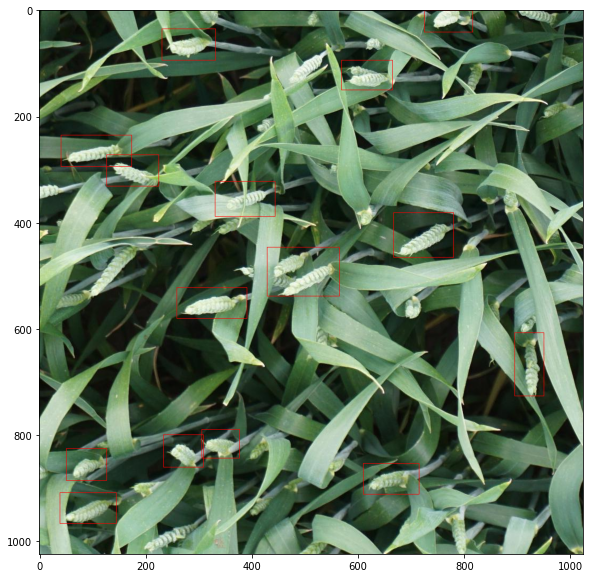

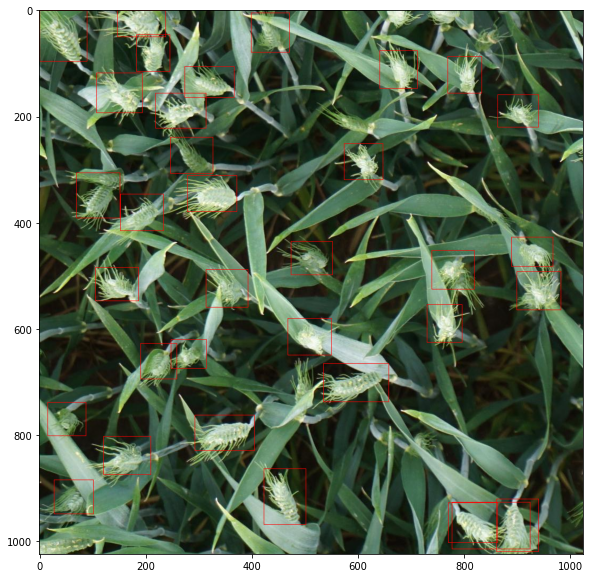

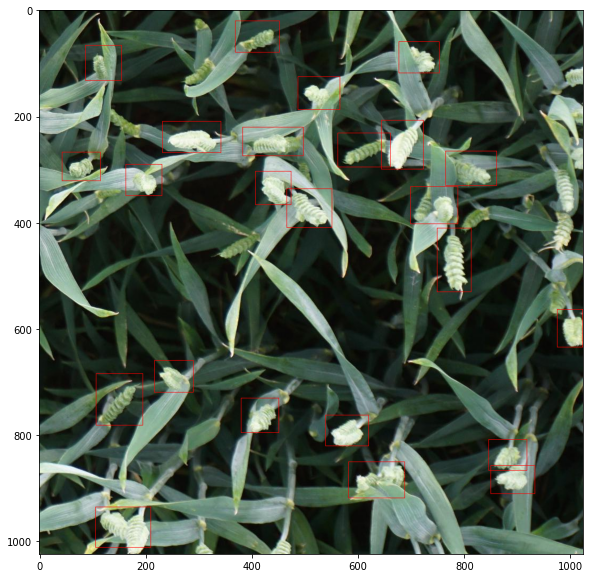

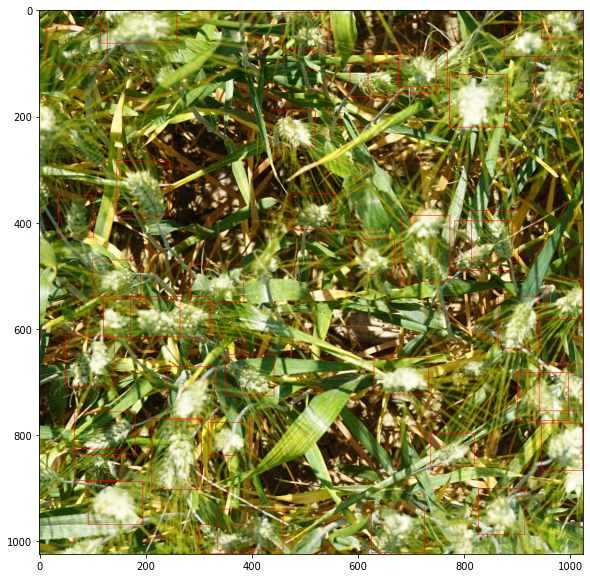

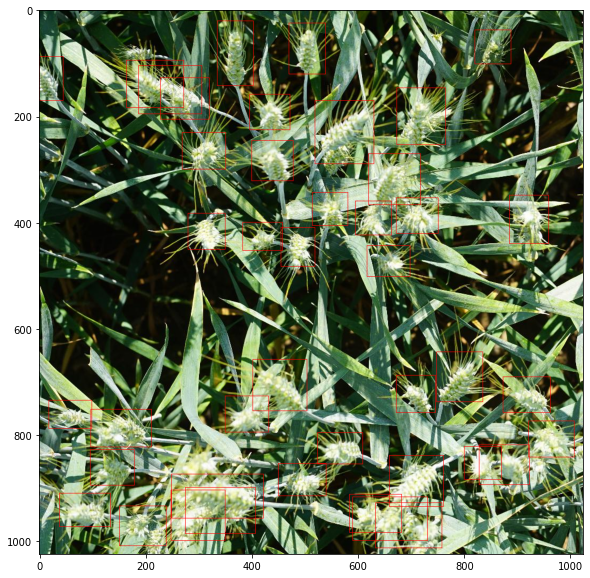

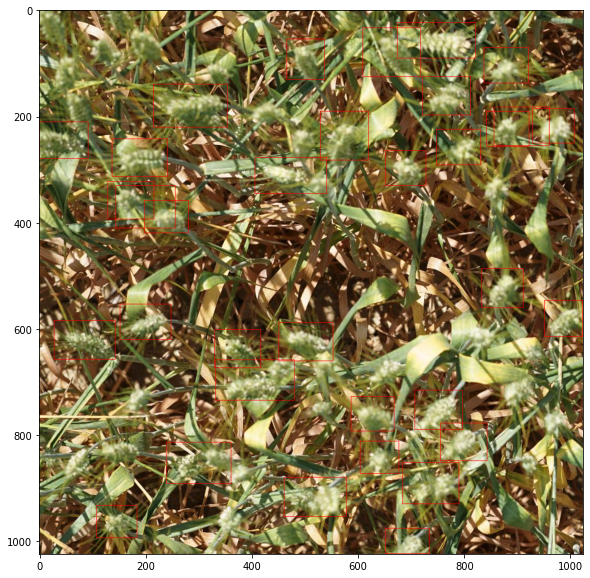

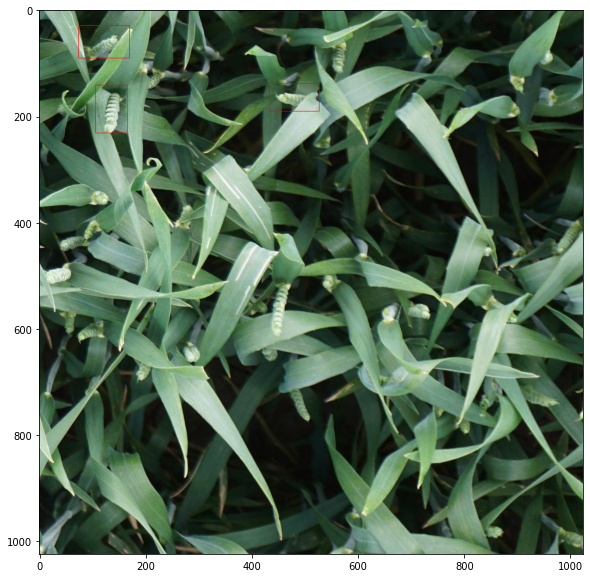

In [5]:
# uncomment to plot detections
# for image_bboxes, image_path in list(zip(pred_bboxes_filtered, val_image_paths))[:10]:
#     image = cv2.imread(image_path)
#     image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
#     for bbox in image_bboxes:
#         cv2.rectangle(
#             image,
#             (bbox[0], bbox[1]),
#             (bbox[0]+bbox[2], bbox[1]+bbox[3]),
#             (255,0,0)
#         )
#     plt.figure(figsize=(10,10))
#     plt.imshow(image)
#     plt.show()